<h3>KDD Cup 2009 Orange Customer Relationships</h3>

 KDD Cup is the annual Data Mining and Knowledge Discovery competition organized by ACM Special Interest Group on Knowledge Discovery and Data Mining, the leading professional organization of data miners.

 In the The KDD Cup 2009, a large marketing databases from the French Telecom company Orange had been offered to work on to predict the propensity of customers to

- switch provider (churn),
- buy new products or services (appetency),
- make the sale more profitable (up-selling)

In this dataset, there are all meaningless header names for the features. That's why we need to understand the relations between those features. The most important point for the analysis is to visualise these relations and put a theory that these relations fit in. We shall clean the data first and visualise. Later with the right questions and analysing those questions, we can find the right model for the best performance for predictions.

In [1]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns

In [3]:
import os
os.getcwd()

'C:\\Users\\abc\\Code_base'

In [4]:
# changing directory
os.chdir('C:/Users/abc/Documents/kdd 2019')     

In [55]:
# loading the data
train = pd.read_table('orange_small_train.data')
train.head() # printing first few 5 rows

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [5]:
train.shape

(50000, 230)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


In [9]:
# loading the target variable appetency
appetency = pd.read_table('orange_small_train_appetency.labels', header = None).loc[:, 0].astype('category')

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [10]:
# no of rows
appetency.shape

(50000,)

In [11]:
# loading the target variable churn and upselling
churn = pd.read_table('orange_small_train_churn.labels', header = None,sep='\t').loc[:, 0].astype('category')
upselling= pd.read_table('orange_small_train_upselling.labels', header = None,sep='\t').loc[:, 0].astype('category')

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


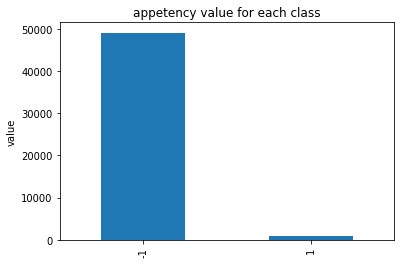

In [10]:
# plotting bar plot of target values
appetency.value_counts().plot.bar()
plt.ylabel('value')
plt.title('appetency value for each class')
plt.show()

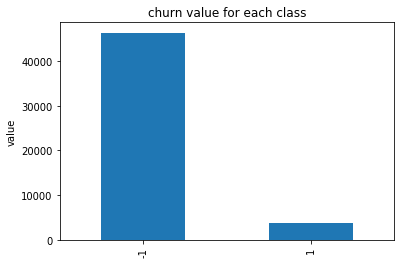

In [11]:
churn.value_counts().plot.bar()
plt.ylabel('value')
plt.title('churn value for each class')
plt.show()

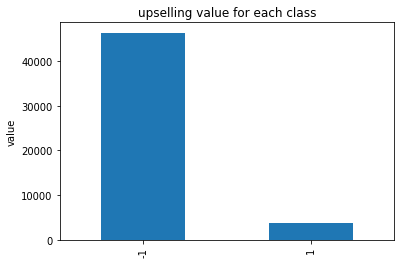

In [12]:
upselling.value_counts().plot.bar()
plt.ylabel('value')
plt.title('upselling value for each class')
plt.show()

* The above 3 plots shows that data is highly unbalanced so we should apply oversampling to balance the data while modelling.

In [13]:
train.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1.487000e+03,44471.000000,44461.000000,0.0,702.000000,1.487000e+03,...,1.241000e+03,1241.000000,0.0,702.000000,702.00000,1241.000000,21022.000000,333.000000,0.0,0.0
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,NaN,48.145299,3.926057e+05,...,7.777380e+04,8.460919,NaN,3.299145,16.54416,167.368477,270.142137,22007.045192,NaN,NaN
std,40.709951,0.141933,4270.193518,1.275481,6.441259e+05,2685.693668,6.326053,NaN,154.777855,9.280896e+05,...,2.016188e+05,46.973777,NaN,8.781967,60.22303,113.980072,86.707692,29085.146490,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,-6.420000,6.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,4.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,19.380000,204.000000,2732.670000,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,20.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,4.00000,197.640000,270.000000,12668.940000,NaN,NaN
75%,16.000000,0.000000,0.000000,0.000000,1.187425e+05,1428.000000,7.000000,NaN,46.000000,2.628630e+05,...,4.881000e+04,8.000000,NaN,6.000000,14.00000,252.960000,330.000000,29396.340000,NaN,NaN
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,NaN,2300.000000,1.232559e+07,...,3.048400e+06,1200.000000,NaN,102.000000,910.00000,628.620000,642.000000,230427.000000,NaN,NaN


<h3> Data Cleaning </h3>

In [56]:
for i in train.columns:
    if train[i].dtypes==float:
        train[i].fillna(train[i].median(),inplace=True)

In [57]:
# changing the datatype of features
DataVars = train.columns
data_types = {Var: train[Var].dtype for Var in DataVars}

for Var in DataVars:
    if data_types[Var] == int:
        x = train[Var].astype(float)
        train.loc[:, Var] = x
        data_types[Var] = x.dtype
    elif data_types[Var] != float:
        x = train[Var].astype('category')
        train.loc[:, Var] = x
        data_types[Var] = x.dtype

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: category(39), float64(191)
memory usage: 78.6 MB


In [59]:
# storing all the float datatype features
float_DataVars = [Var for Var in DataVars if data_types[Var] == float]

In [60]:
#float_x_means = train.median()

for Var in float_DataVars:
    x = train[Var]
    mediancol=train[Var].median()
    isThereMissing = x.isnull()
    if isThereMissing.sum() > 0:
        train.loc[isThereMissing.tolist(), Var] = mediancol 

In [21]:
# changing the datatype of features

DataVars = train.columns
data_types = {Var: train[Var].dtype for Var in DataVars}
# storing all the float datatype features
float_DataVars = [Var for Var in DataVars if data_types[Var] == float]

Text(0, 0.5, 'Frequency')

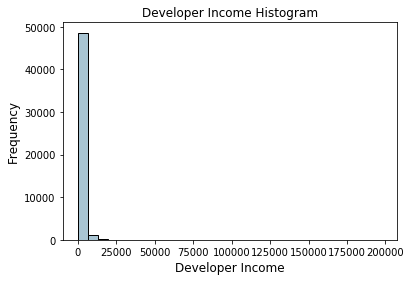

In [55]:
fig, ax = plt.subplots()
dummy['Var13'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
ax.set_title('Developer Income Histogram', fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [56]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = dummy['Var6'].quantile(quantile_list)
quantiles

0.00         0.0
0.25       581.0
0.50       861.0
0.75      1316.0
1.00    131761.0
Name: Var6, dtype: float64

Text(0, 0.5, 'Frequency')

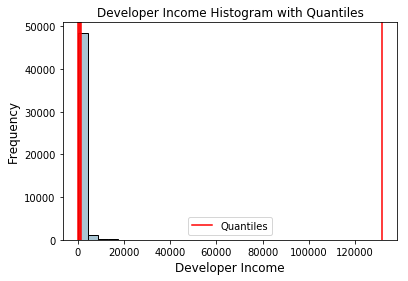

In [57]:
fig, ax = plt.subplots()
dummy['Var6'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Developer Income Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [63]:
# storing all the categpry features
DataVars = train.columns

categorical_DataVars = [Var for Var in DataVars if data_types[Var] != float]


In [64]:
categorical_levels = train[categorical_DataVars].apply(lambda col: len(col.cat.categories))

In [65]:
categorical_x_var_names = categorical_levels[categorical_levels <= 1000].index

In [66]:
collapsed_categories = {}
removed_categorical_x_var_names = set()

for categorical_x_var_name in categorical_x_var_names:
  
    missing_value_row_yesno = train[categorical_x_var_name].isnull()
    if missing_value_row_yesno.sum() > 0:
        train[categorical_x_var_name].cat.add_categories('zzzMISSING', inplace=True)
        train.ix[missing_value_row_yesno.tolist(), categorical_x_var_name] = 'zzzMISSING'

    x = train[categorical_x_var_name].copy()
    for category in x.cat.categories:
        matching_rows_yesno = x == category
        if matching_rows_yesno.sum() < .05 * len(train):
            if categorical_x_var_name in collapsed_categories:
                collapsed_categories[categorical_x_var_name].append(category) 
            else:
                collapsed_categories[categorical_x_var_name] = [category]
            if 'zzzOTHER' not in train[categorical_x_var_name].cat.categories:
                train[categorical_x_var_name].cat.add_categories('zzzOTHER', inplace=True)
            train.ix[matching_rows_yesno, categorical_x_var_name] = 'zzzOTHER'
            train[categorical_x_var_name].cat.remove_categories(category, inplace=True)
  
    categories = train[categorical_x_var_name].cat.categories
    if (len(categories) == 1) or\
        (len(set(categories) - set(['zzzMISSING', 'zzzOTHER'])) < 2):
        removed_categorical_x_var_names.add(categorical_x_var_name)

categorical_x_var_names = list(set(categorical_x_var_names) - removed_categorical_x_var_names)

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [67]:
x_var_names = list(float_DataVars) + list(categorical_x_var_names)
#print(x_var_names)
train = train[x_var_names]

nb_x_vars = len(x_var_names)

nb_x_vars

208

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 208 entries, Var1 to Var207
dtypes: category(17), float64(191)
memory usage: 73.7 MB


In [70]:
train_data=train.copy()

In [71]:
lst=[]
for i in train_data.columns:
    if train_data[i].dtypes!=float:
        lst.append(i)
lst        

['Var197',
 'Var203',
 'Var212',
 'Var206',
 'Var229',
 'Var225',
 'Var228',
 'Var227',
 'Var226',
 'Var205',
 'Var218',
 'Var221',
 'Var208',
 'Var193',
 'Var211',
 'Var223',
 'Var207']

In [72]:
train_data_1 = pd.get_dummies(train_data, columns=['Var197',
 'Var203',
 'Var212',
 'Var206',
 'Var229',
 'Var225',
 'Var228',
 'Var227',
 'Var226',
 'Var205',
 'Var218',
 'Var221',
 'Var208',
 'Var193',
 'Var211',
 'Var223',
 'Var207'])

In [30]:
'''from sklearn.preprocessing import OneHotEncoder, LabelEncoder
gen_le = LabelEncoder()
for i in train_data.columns:
    if train_data[i].dtypes!=float:
        gen_labels = gen_le.fit_transform(train_data[i])
        train_data[i+'_Label'] = gen_labels
        train_data.drop(i,axis=1,inplace=True)

#poke_df['Gen_Label'] = gen_labels

In [73]:
train_data_1.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var211_L84s,Var211_Mtgm,Var223_LM8l689qOp,Var223_jySVZNlOJy,Var223_zzzMISSING,Var223_zzzOTHER,Var207_7M47J5GA0pTYIFxg5uy,Var207_DHn_WUyBhW_whjA88g9bvA64_,Var207_me75fM6ugJ,Var207_zzzOTHER
0,0.0,0.0,0.0,0.0,0.0,1526.0,7.0,NaN,20.0,0.0,...,1,0,0,1,0,0,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,525.0,0.0,NaN,20.0,0.0,...,1,0,1,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,5236.0,7.0,NaN,20.0,0.0,...,1,0,0,1,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,861.0,0.0,NaN,20.0,0.0,...,0,1,1,0,0,0,0,0,1,0
4,0.0,0.0,0.0,0.0,0.0,1029.0,7.0,NaN,20.0,0.0,...,1,0,1,0,0,0,0,0,1,0


In [74]:
for i in train_data_1.columns:
    if train_data_1[i].dtypes==float:
        mean_value = train_data_1[i].mean()
        std_value = train_data_1[i].std()
        train_data_1[i]=(train_data_1[i] - mean_value) / (std_value)

In [75]:
nulls = train_data_1.isnull().sum()
nulls[nulls > 0]

Var8      50000
Var15     50000
Var20     50000
Var31     50000
Var32     50000
Var39     50000
Var42     50000
Var48     50000
Var52     50000
Var55     50000
Var79     50000
Var118    50000
Var141    50000
Var167    50000
Var169    50000
Var175    50000
Var185    50000
Var209    50000
Var230    50000
dtype: int64

In [76]:
train_data_1.drop(['Var8', 'Var15', 
                'Var20','Var31','Var32','Var39','Var42','Var48','Var52','Var55','Var79','Var141', 'Var167','Var169','Var175','Var185','Var209','Var230'], axis=1, inplace=True)

In [77]:
nulls = train_data_1.isnull().sum()
nulls[nulls > 0]

Var118    50000
dtype: int64

In [78]:
train_data_1.drop(['Var118'], axis=1, inplace=True)

In [79]:
train_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 243 entries, Var1 to Var207_zzzOTHER
dtypes: float64(172), uint8(71)
memory usage: 69.0 MB


In [45]:
train_data_1.shape

(50000, 244)

### Taking target variable as churn

In [80]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1 , churn , stratify=churn, test_size=0.2, random_state=42)

In [81]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train , y_train , stratify=y_train, test_size=0.2, random_state=42)

In [48]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':[500,1000]}

random_grid = GridSearchCV(random_classifier, parameters, cv = 3)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 5, 'n_estimators': 500}


In [82]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    #criterion='entropy',
    max_depth=5,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [83]:
rf_pred_probs=rf_model.predict(X_cv)

In [84]:
auc=metrics.roc_auc_score(y_cv,rf_pred_probs)
auc

0.6575552239244321

In [85]:
rf_pred_probs=rf_model.predict(X_test)

In [86]:
auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.6433808285660682

In [90]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:80].index

Index(['Var126', 'Var212_NhsEn4L', 'Var189', 'Var218_zzzOTHER', 'Var74',
       'Var113', 'Var218_cJvF', 'Var81', 'Var205_sJzTlal', 'Var140', 'Var57',
       'Var28', 'Var13', 'Var125', 'Var94', 'Var38', 'Var193_RO12', 'Var45',
       'Var134', 'Var229_zzzMISSING', 'Var6', 'Var76', 'Var153', 'Var83',
       'Var149', 'Var163', 'Var119', 'Var218_UYBR', 'Var133', 'Var21', 'Var24',
       'Var160', 'Var35', 'Var123', 'Var112', 'Var225_zzzMISSING', 'Var25',
       'Var109', 'Var144', 'Var227_ZI9m', 'Var85', 'Var188',
       'Var206_zzzMISSING', 'Var205_VpdQ', 'Var65', 'Var229_am7c', 'Var22',
       'Var221_zCkv', 'Var168', 'Var44', 'Var152', 'Var139', 'Var197_zzzOTHER',
       'Var7', 'Var207_zzzOTHER', 'Var51', 'Var107', 'Var228_F2FyR07IdsN7I',
       'Var212_XfqtO3UdzaXh_', 'Var226_zzzOTHER', 'Var227_6fzt',
       'Var193_2Knk1KF', 'Var68', 'Var206_zm5i', 'Var132', 'Var211_L84s',
       'Var111', 'Var197_lK27', 'Var102', 'Var193_zzzOTHER',
       'Var223_zzzMISSING', 'Var207_me75fM6ugJ',

In [91]:
train_data_1=train_data_1[['Var126', 'Var212_NhsEn4L', 'Var189', 'Var218_zzzOTHER', 'Var74',
       'Var113', 'Var218_cJvF', 'Var81', 'Var205_sJzTlal', 'Var140', 'Var57',
       'Var28', 'Var13', 'Var125', 'Var94', 'Var38', 'Var193_RO12', 'Var45',
       'Var134', 'Var229_zzzMISSING', 'Var6', 'Var76', 'Var153', 'Var83',
       'Var149', 'Var163', 'Var119', 'Var218_UYBR', 'Var133', 'Var21', 'Var24',
       'Var160', 'Var35', 'Var123', 'Var112', 'Var225_zzzMISSING', 'Var25',
       'Var109', 'Var144', 'Var227_ZI9m', 'Var85', 'Var188',
       'Var206_zzzMISSING', 'Var205_VpdQ', 'Var65', 'Var229_am7c', 'Var22',
       'Var221_zCkv', 'Var168', 'Var44', 'Var152', 'Var139', 'Var197_zzzOTHER',
       'Var7', 'Var207_zzzOTHER', 'Var51', 'Var107', 'Var228_F2FyR07IdsN7I',
       'Var212_XfqtO3UdzaXh_', 'Var226_zzzOTHER', 'Var227_6fzt',
       'Var193_2Knk1KF', 'Var68', 'Var206_zm5i', 'Var132', 'Var211_L84s',
       'Var111', 'Var197_lK27', 'Var102', 'Var193_zzzOTHER',
       'Var223_zzzMISSING', 'Var207_me75fM6ugJ', 'Var229_mj86', 'Var59',
       'Var226_7P5s', 'Var19', 'Var72', 'Var228_ib5G6X1eUxUn6', 'Var206_haYg',
       'Var226_Aoh3']]

In [92]:
train_data_1.head()

,Var126,Var212_NhsEn4L,Var189,Var218_zzzOTHER,Var74,Var113,Var218_cJvF,Var81,Var205_sJzTlal,Var140,...,Var223_zzzMISSING,Var207_me75fM6ugJ,Var229_mj86,Var59,Var226_7P5s,Var19,Var72,Var228_ib5G6X1eUxUn6,Var206_haYg,Var226_Aoh3
0,0.378521,0,3.413988,0,-0.080083,0.355810,1,-0.918831,0,-0.282393,...,0,1,0,-0.040774,0,-0.024235,-0.362898,0,1,0
1,0.170716,1,-0.001063,1,-0.128450,-0.266798,0,0.509515,1,-0.331328,...,0,1,0,-0.040774,0,-0.024235,-0.362898,0,0,0
2,-1.491725,0,-0.001063,0,0.587383,0.733389,0,-0.830621,0,-0.119721,...,0,0,0,-0.040774,0,-0.024235,-0.362898,1,1,0
3,-0.764407,1,-0.001063,0,-0.128450,-0.160795,0,-0.261215,0,-0.331328,...,0,1,0,-0.040774,0,-0.024235,-0.362898,0,0,0
4,2.976086,0,-0.001063,0,0.181100,0.215392,0,-0.619876,1,0.529648,...,0,1,1,-0.040774,0,-0.024235,-0.362898,0,0,0


In [93]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1 , churn , stratify=churn, test_size=0.2, random_state=42)
X_train,X_cv, y_train, y_cv = train_test_split(X_train , y_train , stratify=y_train, test_size=0.2, random_state=42)

In [94]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':[500,1000]}

random_grid = GridSearchCV(random_classifier, parameters, cv = 3)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 5, 'n_estimators': 500}


In [95]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    #criterion='entropy',
    max_depth=5,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [96]:
rf_pred_probs=rf_model.predict(X_cv)

auc=metrics.roc_auc_score(y_cv,rf_pred_probs)
auc

0.6566374256124469

In [97]:
rf_pred_probs=rf_model.predict(X_test)

auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.6432729071328716

<h3> Taking target variable as appetency</h3>

## 1. Random Forest Classifer Model

In [105]:
# concatenating all the target variables
labels = pd.concat([appetency, churn, upselling],axis=1)
labels.columns = ['appetency', 'churn', 'upselling']
# concatenate the data with the target variable
data = pd.concat([train_data_1,labels],axis=1)

In [106]:
datatrain = data.drop(['churn','upselling'],axis=1)
X=datatrain
y=datatrain['appetency']
X_train,X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=42)
print("X_train shape is",X_train.shape,'\n','X_test shape is',X_test.shape)
y_test=X_test['appetency']
X_test=X_test.drop(['appetency'],axis=1)
df_maj = X_train[X_train.appetency==-1]
df_min = X_train[X_train.appetency==1]
# performing oversampling only on train dataset
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

df_upsampled = pd.concat([df_maj, df_min_upsampled])
y_train = df_upsampled['appetency']
X_train = df_upsampled.drop(['appetency'],axis=1)


X_train shape is (35000, 81) 
 X_test shape is (15000, 81)


In [107]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train , y_train , stratify=y_train, test_size=0.2, random_state=42)

In [108]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':[500,1000]}

random_grid = GridSearchCV(random_classifier, parameters, cv = 5)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 9, 'n_estimators': 1000}


In [109]:
# Applying Random Forest classifier model

rf_model = RandomForestClassifier(
    n_estimators=1000,
    #criterion='entropy',
    max_depth=9,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [110]:
rf_pred_probs=rf_model.predict(X_cv)

auc=metrics.roc_auc_score(y_cv,rf_pred_probs)
auc

0.9043036226135702

In [111]:
rf_pred_probs=rf_model.predict(X_test)

auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.7323885765883665

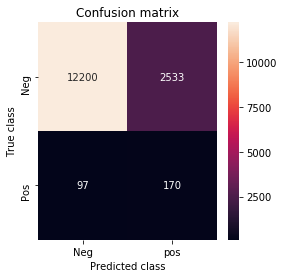

In [112]:
# Printing Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, rf_pred_probs)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Taking target variable as Upselling

In [113]:
# concatenating all the target variables
labels = pd.concat([appetency, churn, upselling],axis=1)
labels.columns = ['appetency', 'churn', 'upselling']
# concatenate the data with the target variable
data = pd.concat([train_data_1,labels],axis=1)

In [114]:
datatrain = data.drop(['appetency','churn'],axis=1)
X=datatrain
y=datatrain['upselling']
X_train,X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=42)
print("X_train shape is",X_train.shape,'\n','X_test shape is',X_test.shape)
y_test=X_test['upselling']
X_test=X_test.drop(['upselling'],axis=1)
df_maj = X_train[X_train.upselling==-1]
df_min = X_train[X_train.upselling==1]
# performing oversampling only on train dataset
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

df_upsampled = pd.concat([df_maj, df_min_upsampled])
y_train = df_upsampled['upselling']
X_train = df_upsampled.drop(['upselling'],axis=1)



X_train shape is (35000, 81) 
 X_test shape is (15000, 81)


In [115]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train , y_train , stratify=y_train, test_size=0.2, random_state=42)

In [116]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':[500,1000]}

random_grid = GridSearchCV(random_classifier, parameters, cv = 5)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 9, 'n_estimators': 1000}


In [117]:
rf_model = RandomForestClassifier(
    n_estimators=1000,
    #criterion='entropy',
    max_depth=9,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [118]:
rf_pred_probs=rf_model.predict(X_cv)

auc=metrics.roc_auc_score(y_cv,rf_pred_probs)
auc

0.8506553585196608

In [119]:
rf_pred_probs=rf_model.predict(X_test)

auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.7338469354027214

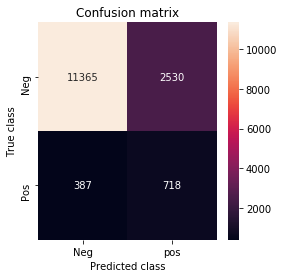

In [120]:
conf_matrix = metrics.confusion_matrix(y_test, rf_pred_probs)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [121]:
train_data_1.to_csv('train_data_1.csv')

In [5]:
train=pd.read_csv('train_data_1.csv')

## 2. XGBOOST Classifier Model

### Taking target variable as appetency

In [39]:
# concatenating all the target variables
labels = pd.concat([appetency, churn, upselling],axis=1)
labels.columns = ['appetency', 'churn', 'upselling']
# concatenate the data with the target variable
data = pd.concat([train,labels],axis=1)

In [22]:
def grid(X, y):
    param_grid = {
        'gamma': [0, 0.001, 0.01, 0.1],
        'n_estimators':[10,20,30],
        'max_depth':[3,4,5]
        
    }

    grid = GridSearchCV(XGBClassifier(), param_grid, refit=True, verbose=3, scoring='roc_auc', n_jobs=4)
    grid.fit(X, y.values.ravel())
    
    print('Params', grid.best_params_)
    print('AUC-Score', grid.best_score_)

    return grid

In [40]:
datatrain = data.drop(['churn','upselling'],axis=1)
X=datatrain
y=datatrain['appetency']
X_train,X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=42)
print("X_train shape is",X_train.shape,'\n','X_test shape is',X_test.shape)
y_test=X_test['appetency']
X_test=X_test.drop(['appetency'],axis=1)
df_maj = X_train[X_train.appetency==-1]
df_min = X_train[X_train.appetency==1]
# performing oversampling only on train dataset
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

df_upsampled = pd.concat([df_maj, df_min_upsampled])
y_train = df_upsampled['appetency']
X_train = df_upsampled.drop(['appetency'],axis=1)


X_train shape is (35000, 82) 
 X_test shape is (15000, 82)


In [24]:
appetency_result = grid(X_train, y_train)

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   48.0s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  4.0min finished


Params {'gamma': 0, 'max_depth': 5, 'n_estimators': 30}
AUC-Score 0.9219248395821344


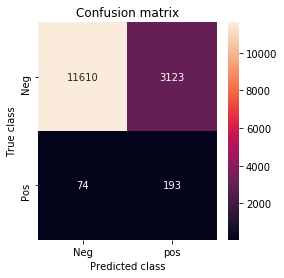

In [41]:
clf=XGBClassifier(n_estimators=10,max_depth=3,nthread=4,subsample=1,gamma=0,objective='binary:logistic')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [42]:
auc = metrics.roc_auc_score(y_test,predictions)
auc

0.7554366601918646

### Taking target variable as churn

In [43]:
# concatenating all the target variables
labels = pd.concat([appetency, churn, upselling],axis=1)
labels.columns = ['appetency', 'churn', 'upselling']
# concatenate the data with the target variable
data = pd.concat([train,labels],axis=1)

In [44]:
datatrain = data.drop(['appetency','upselling'],axis=1)
X=datatrain
y=datatrain['churn']
X_train,X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=42)
print("X_train shape is",X_train.shape,'\n','X_test shape is',X_test.shape)
y_test=X_test['churn']
X_test=X_test.drop(['churn'],axis=1)
df_maj = X_train[X_train.churn==-1]
df_min = X_train[X_train.churn==1]
# performing oversampling only on train dataset
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

df_upsampled = pd.concat([df_maj, df_min_upsampled])
y_train = df_upsampled['churn']
X_train = df_upsampled.drop(['churn'],axis=1)



X_train shape is (35000, 82) 
 X_test shape is (15000, 82)


In [31]:
churn_result = grid(X_train, y_train)

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  3.5min finished


Params {'gamma': 0, 'max_depth': 5, 'n_estimators': 30}
AUC-Score 0.7839369175706988


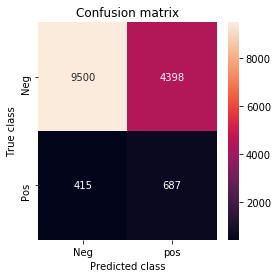

In [47]:
clf=XGBClassifier(n_estimators=30,max_depth=5,nthread=4,subsample=1,gamma=0,objective='binary:logistic')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [48]:
auc = metrics.roc_auc_score(y_test,predictions)
auc

0.6534817841891364

### Taking target variable as Upselling

In [34]:
# concatenating all the target variables
labels = pd.concat([appetency, churn, upselling],axis=1)
labels.columns = ['appetency', 'churn', 'upselling']
# concatenate the data with the target variable
data = pd.concat([train,labels],axis=1)

In [35]:
datatrain = data.drop(['appetency','churn'],axis=1)
X=datatrain
y=datatrain['upselling']
X_train,X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=42)
print("X_train shape is",X_train.shape,'\n','X_test shape is',X_test.shape)
y_test=X_test['upselling']
X_test=X_test.drop(['upselling'],axis=1)
df_maj = X_train[X_train.upselling==-1]
df_min = X_train[X_train.upselling==1]
# performing oversampling only on train dataset
df_min_upsampled = resample(df_min, 
                                replace=True,     # sample with replacement
                                 n_samples=df_maj.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

df_upsampled = pd.concat([df_maj, df_min_upsampled])
y_train = df_upsampled['upselling']
X_train = df_upsampled.drop(['upselling'],axis=1)



X_train shape is (35000, 82) 
 X_test shape is (15000, 82)


In [36]:
upselling_result = grid(X_train, y_train)

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  3.5min finished


Params {'gamma': 0, 'max_depth': 5, 'n_estimators': 30}
AUC-Score 0.8881705647707435


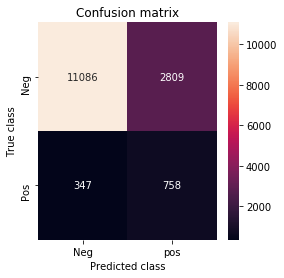

In [37]:
clf=XGBClassifier(n_estimators=30,max_depth=5,nthread=4,subsample=1,gamma=0,objective='binary:logistic')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,xticklabels=['Neg','pos'], yticklabels=['Neg','Pos'],fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [38]:
auc = metrics.roc_auc_score(y_test,predictions)
auc

0.7419069003303704

In [49]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Target Variable", "Test AUC"]
x.add_row(['Random Forest Classifier','appetency','0.732'])
x.add_row(['Random Forest Classifier','churn','0.643'])
x.add_row(['Random Forest Classifier','upselling','0.733'])
x.add_row(['XGBOOST Classifier','appetency','0.755'])
x.add_row(['XGBOOST Classifier','churn','0.653'])
x.add_row(['XGBOOST Classifier','upselling','0.741'])
print(x)

+--------------------------+-----------------+----------+
|        Model Name        | Target Variable | Test AUC |
+--------------------------+-----------------+----------+
| Random Forest Classifier |    appetency    |  0.732   |
| Random Forest Classifier |      churn      |  0.643   |
| Random Forest Classifier |    upselling    |  0.733   |
|    XGBOOST Classifier    |    appetency    |  0.755   |
|    XGBOOST Classifier    |      churn      |  0.653   |
|    XGBOOST Classifier    |    upselling    |  0.741   |
+--------------------------+-----------------+----------+


### Steps to be followed

1. Acquiring the dataset.
2. Clean the dataset and get it into a format convenient for analysis.
3. Summarizing and visualizing important characteristics and statistical properties of the dataset.
4. Appling Machine Learning. Building models to predict the customer relationship behaviour, evaluate the results of models, and eventually, choose the best suitable predictive model .

### Refereces

* https://www.kaggle.com/asminalev/kddcup-2009-data-analysis
* https://github.com/jjmanrique/KDD-Cup-2009/blob/master/KDD_small.ipynb
    